In [1]:
from datetime import date
from enum import Enum

%load_ext google.cloud.bigquery
from google.cloud import bigquery

import pandas as pd
import numpy as np

In [2]:
project = "celo-testnet"
client = bigquery.Client(project)
for dataset in client.list_datasets():
    print(dataset.dataset_id)

dataflow_metrics
load_test_data
segment_data
segment_data_events
segment_data_metrics
tme_test_stakeoff
transaction_data
transaction_metrics_exporter


In [3]:
partition = date.today().strftime("%Y%m%d")
# partition = 20200316
# partition = "*"
dataset = "transaction_metrics_exporter"
table = "transaction_metrics_exporter_{0}".format(partition)
tme = client.get_dataset(dataset)
table_path = ".".join([project, dataset, table])
table_path = "celo-testnet.tme_test_stakeoff.tme_stakeoff_test_*"
print(table_path)

celo-testnet.tme_test_stakeoff.tme_stakeoff_test_*


In [4]:
class EventTypes(Enum):
    RECEIVED_BLOCK="RECEIVED_BLOCK"
    RECEIVED_STATE="RECEIVED_STATE"
    RECEIVED_TRANSACTION="RECEIVED_TRANSACTION"
    RECEIVED_TRANSACTION_RECEIPT="RECEIVED_TRANSACTION_RECEIPT"
    RECEIVED_PARSED_TRANSACTION="RECEIVED_PARSED_TRANSACTION"
    RECEIVED_PARSED_LOG="RECEIVED_PARSED_LOG"

In [5]:
query_blocks = f"""
SELECT 
  MAX(T.jsonPayload.timestamp) as timestamp,
  T.jsonPayload.number as blockNumber,
  MAX(T.jsonPayload.gasUsed) as gasUsed,
  MAX(T.jsonPayload.gasLimit) as gasLimit,
  COUNT(T.jsonPayload.transactions) as txAmount
FROM 
  `{table_path}` as T
WHERE
   T.jsonPayload.event='{EventTypes.RECEIVED_BLOCK.value}'
GROUP BY blockNumber
ORDER BY blockNumber DESC 
"""

df_blocks = client.query(
    query_blocks, 
    job_config=bigquery.QueryJobConfig(
        query_parameters=[]
    )
).to_dataframe()

df_blocks['blocktime'] = df_blocks[::-1].diff(axis=0).timestamp

df_blocks.describe()

,timestamp,blockNumber,gasUsed,gasLimit,txAmount,blocktime
count,2.350200e+04,23502.000000,2.350200e+04,23502.0,23502.000000,23501.000000
mean,1.579812e+09,221539.979023,6.953354e+04,20000000.0,1.649009,177.883452
std,1.219331e+06,242199.074340,1.901662e+05,0.0,1.052668,366.461046
min,1.578698e+09,500.000000,0.000000e+00,20000000.0,1.000000,5.000000
25%,1.578776e+09,15828.250000,0.000000e+00,20000000.0,1.000000,5.000000
50%,1.579230e+09,105863.000000,0.000000e+00,20000000.0,1.000000,130.000000
75%,1.580774e+09,412519.500000,4.858100e+04,20000000.0,3.000000,370.000000
max,1.582878e+09,822500.000000,1.095853e+07,20000000.0,14.000000,48283.000000


In [6]:
df_blocks.head()

,timestamp,blockNumber,gasUsed,gasLimit,txAmount,blocktime
0,1.582878e+09,822500.0,375081.0,20000000.0,3,1641.0
1,1.582877e+09,822400.0,208426.0,20000000.0,3,1664.0
2,1.582875e+09,822300.0,108726.0,20000000.0,3,1787.0
3,1.582873e+09,822200.0,177222.0,20000000.0,3,1072.0
4,1.582872e+09,822100.0,91069.0,20000000.0,3,1110.0


last block  : 822500 on 1582878345.0
first block : 500 on 1578697906.0
blocks load : 23502
transactions: 38755
mean gasUsed: 69534 GcWei
mean blocktime: 178 s


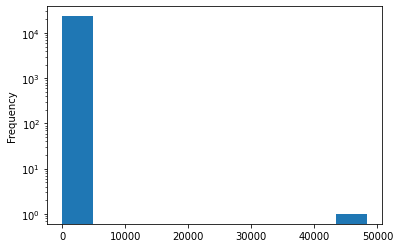

In [7]:
last_block, first_block = df_blocks.blockNumber.max(), df_blocks.blockNumber.min()
print(f"last block  : {last_block:.0f} on {df_blocks.timestamp.max()}") 
print(f"first block : {first_block:.0f} on {df_blocks.timestamp.min()}")
print(f"blocks load : {df_blocks.timestamp.count():.0f}")
print(f"transactions: {df_blocks.txAmount.sum()}")
print(f"mean gasUsed: {df_blocks.gasUsed.mean():.0f} GcWei")
df_blocks.blocktime.plot.hist(logy=True)
print(f"mean blocktime: {df_blocks.blocktime.mean():.0f} s")

In [8]:
query_state = f"""
SELECT
  timestamp,
  jsonPayload.blockNumber,
  jsonPayload.values.rewardsamount,
  jsonPayload.values.rewardsmultiplier,
  jsonPayload.values.medianRate,
  jsonPayload.values.currentStableBucket,
  jsonPayload.values.currentGoldBucket,
  jsonPayload.values.goldTokenTotalSupply
FROM 
  `{table_path}` as T
WHERE 
  jsonPayload.event='{EventTypes.RECEIVED_STATE.value}'
ORDER BY 
  T.jsonPayload.blockNumber DESC,
  T.timestamp DESC
"""

df_state = client.query(
    query_state, 
    job_config=bigquery.QueryJobConfig(
        query_parameters=[]
    )
).to_dataframe()

df_state.describe()

,blockNumber,rewardsamount,rewardsmultiplier,medianRate,currentStableBucket,currentGoldBucket,goldTokenTotalSupply
count,193884.000000,3.878400e+04,3.876800e+04,38758.000000,3.880100e+04,3.880100e+04,3.877300e+04
mean,289998.892565,6.006169e+26,1.605042e+24,3.732639,3.735151e+24,9.964785e+23,1.172967e+26
std,257117.438698,5.473347e+23,1.366802e+22,4.138222,4.137815e+24,8.252984e+21,1.207414e+25
min,500.000000,6.000000e+26,1.569455e+24,0.995000,9.868052e+23,8.558890e+23,1.069011e+26
25%,18948.000000,6.000395e+26,1.595705e+24,0.999000,9.977034e+23,9.974182e+23,1.069011e+26
50%,243300.000000,6.005182e+26,1.611932e+24,1.001000,1.002847e+24,9.989459e+23,1.115655e+26
75%,506426.000000,6.010778e+26,1.616444e+24,10.000000,9.995200e+24,9.995200e+23,1.257684e+26
max,822500.000000,6.017675e+26,1.616726e+24,10.000000,1.000000e+25,1.002487e+24,1.481719e+26


In [9]:
df = df_state \
    .groupby('blockNumber').max() \
    .merge(df_blocks, left_on='blockNumber', right_on='blockNumber', suffixes=('_tme', '_block'))
df['datetime_block'] = pd.to_datetime(df['timestamp_block'],unit='s')
df.tail()

,blockNumber,timestamp_tme,rewardsamount,rewardsmultiplier,medianRate,currentStableBucket,currentGoldBucket,goldTokenTotalSupply,timestamp_block,gasUsed,gasLimit,txAmount,blocktime,datetime_block
23489,822100.0,2020-03-24 11:16:53.868584+00:00,6.017649e+26,1.569503e+24,1.004,9.908442e+23,9.868966e+23,1.481309e+26,1.582872e+09,91069.0,20000000.0,3,1110.0,2020-02-28 06:43:01
23490,822200.0,2020-03-24 11:16:54.314595+00:00,6.017653e+26,1.569504e+24,1.004,9.908442e+23,9.868966e+23,1.481309e+26,1.582873e+09,177222.0,20000000.0,3,1072.0,2020-02-28 07:00:53
23491,822300.0,2020-03-24 11:16:54.904726+00:00,6.017661e+26,1.569455e+24,1.005,9.919736e+23,9.870384e+23,1.481719e+26,1.582875e+09,108726.0,20000000.0,3,1787.0,2020-02-28 07:30:40
23492,822400.0,2020-03-24 11:16:55.494392+00:00,6.017668e+26,1.569456e+24,1.004,9.922852e+23,9.867094e+23,1.481719e+26,1.582877e+09,208426.0,20000000.0,3,1664.0,2020-02-28 07:58:24
23493,822500.0,2020-03-24 11:16:56.239965+00:00,6.017675e+26,1.569458e+24,1.005,9.909564e+23,9.870084e+23,1.481719e+26,1.582878e+09,375081.0,20000000.0,3,1641.0,2020-02-28 08:25:45


Text(0, 0.5, 'SortedOracles.medianRate')

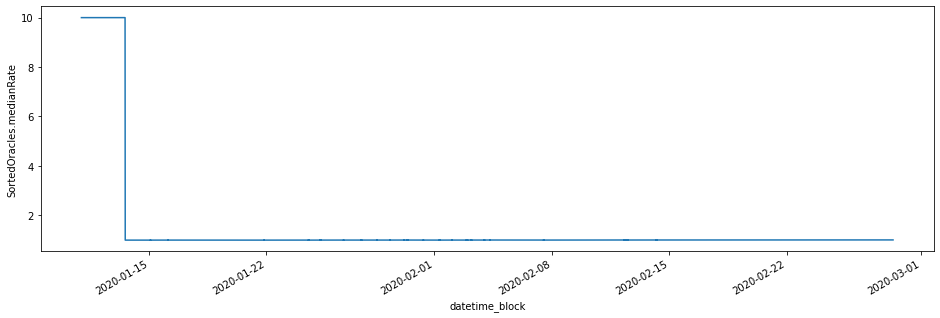

In [10]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 5]
df_sortedOracles = df.set_index('datetime_block')['medianRate']
ax = df_sortedOracles.plot()
ax.set_ylabel("SortedOracles.medianRate")

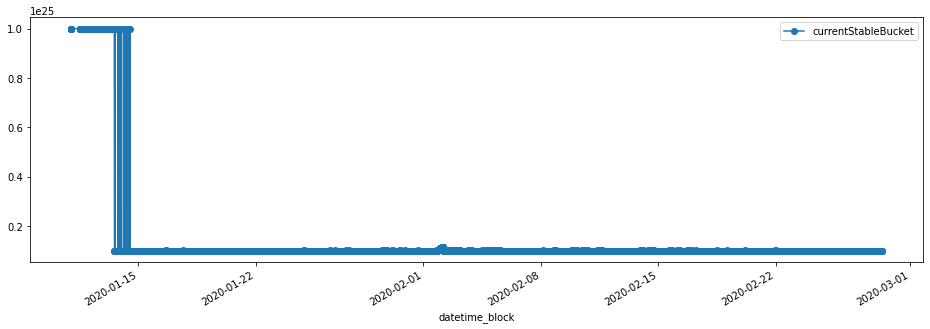

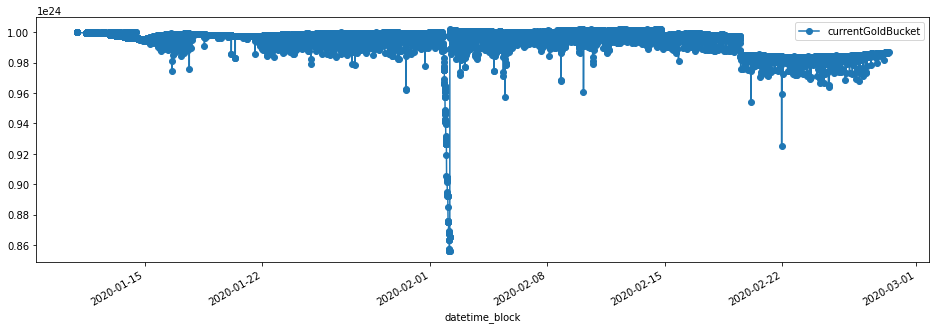

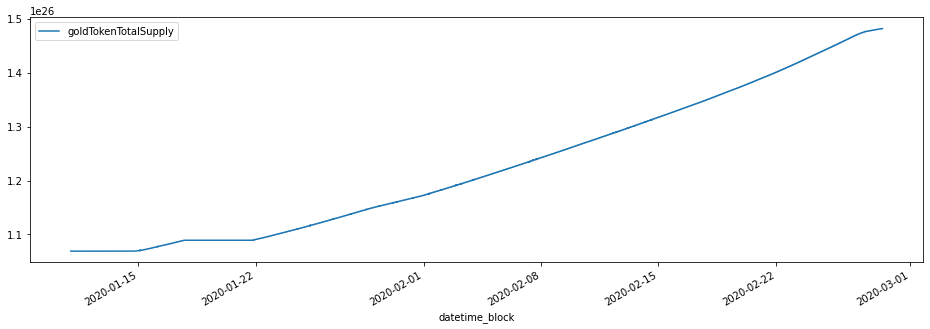

In [11]:
df_stableToken = df.set_index('datetime_block')[['currentStableBucket']].astype('float')
df_stableToken.plot(marker='o')
df_stableToken = df.set_index('datetime_block')[['currentGoldBucket']].astype('float')
df_stableToken.plot(marker='o')
df_goldToken = df.set_index('datetime_block')[['goldTokenTotalSupply']]
ax = df_goldToken.plot()

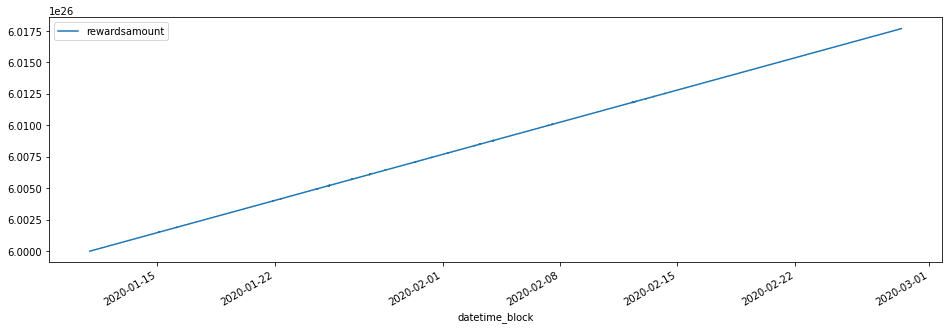

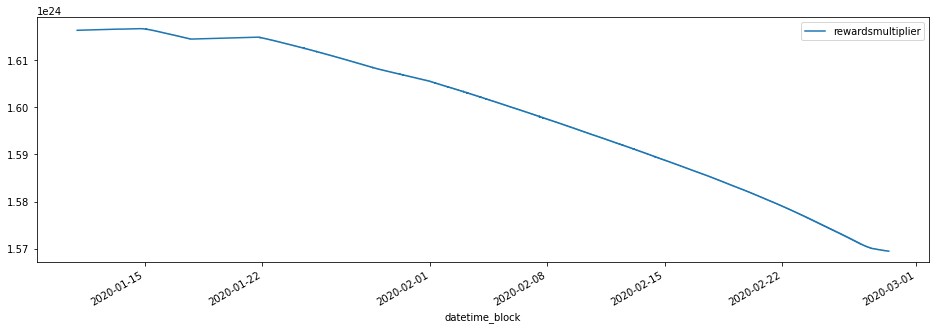

In [12]:
df_rewardsAmount = df.set_index('datetime_block')[['rewardsamount']]
ax = df_rewardsAmount.plot()
df_rewardsMultiplier = df.set_index('datetime_block')[['rewardsmultiplier']]
ax = df_rewardsMultiplier.plot()

In [13]:
query_events = f"""
SELECT
  jsonPayload.blockNumber as blockNumber,
  jsonPayload.returnValues,
  jsonPayload.address,
  jsonPayload.eventName
FROM 
  `{table_path}` as T
WHERE 
      jsonPayload.event='{EventTypes.RECEIVED_PARSED_LOG.value}'
ORDER BY 
  blockNumber DESC
"""

df_events = client.query(
    query_events, 
    job_config=bigquery.QueryJobConfig(
        query_parameters=[]
    )
).to_dataframe()

df_events = pd.concat([
    df_events.drop(['returnValues'], axis=1), 
    df_events['returnValues'].apply(pd.Series)
], axis=1)

df_events.describe()

,blockNumber
count,43851.000000
mean,340907.165880
std,250990.177368
min,505.000000
25%,90726.000000
50%,306026.000000
75%,538226.000000
max,822500.000000


In [14]:
df_events.head()

,blockNumber,address,eventName,identifier,addr,identifierhash,slasheridentifier,account,metadataurl,value,...,exchanger,soldgold,issuer,available,participationbaseline,weight,proposalid,hash,whitelister,timestamp
0,822500.0,0x14D449EF428e679da48B3e8CfFa9036fF404B28A,Transfer,None,None,None,None,None,None,10000,...,None,None,None,None,None,None,None,None,None,None
1,822500.0,0x14D449EF428e679da48B3e8CfFa9036fF404B28A,Transfer,None,None,None,None,None,None,0,...,None,None,None,None,None,None,None,None,None,None
2,822500.0,0x14D449EF428e679da48B3e8CfFa9036fF404B28A,Transfer,None,None,None,None,None,None,0,...,None,None,None,None,None,None,None,None,None,None
3,822500.0,0xC8FD77490A12F46709BffbCC0FCe35740Da8D860,Exchanged,None,None,None,None,None,None,None,...,0xe820238dc7B75B7602DaFC7ffcCd35C9EF5e2fdF,False,None,None,None,None,None,None,None,None
4,822500.0,0x5c7197E1147ebF98658A2a8Bc3D32BeBF1692829,Transfer,None,None,None,None,None,None,0,...,None,None,None,None,None,None,None,None,None,None


In [15]:
df_events.groupby('eventName').eventName.count().sort_values(ascending=False)

eventName
Transfer                          27239
Approval                           5555
Exchanged                          3353
GoldLocked                         2733
ValidatorGroupVoteCast             2722
ValidatorGroupVoteActivated         736
ValidatorGroupVoteRevoked           374
AccountNameSet                      195
AttestationCompleted                180
AttestationIssuerSelected           159
AttestationsRequested               154
RegistryUpdated                      98
AccountMetadataURLSet                55
AccountCreated                       50
SlasherWhitelistAdded                42
ValidatorGroupMemberAdded            27
ValidatorAffiliated                  26
AccountDataEncryptionKeySet          21
ValidatorRegistered                  19
ValidatorSignerAuthorized            14
ValidatorDeaffiliated                14
ValidatorGroupRegistered             12
ValidatorGroupMarkedEligible         11
AttestationSignerAuthorized          10
ValidatorGroupMemberRemoved   

In [16]:
df_exchange = df_events[df_events.eventName == "Exchanged"].set_index('blockNumber')[['exchanger', 'buyamount', 'sellamount', 'soldgold']]
df_exchange[['buyamount','sellamount']] = df_exchange[['buyamount','sellamount']].astype('float')
df_exchange.groupby('exchanger').exchanger.count().sort_values(ascending=False)

exchanger
0x1DBe73b0480058106798Adda62E25d5279233c1B    194
0xe5DE9f2d1535D5b2CF8D0BA91d1F92C475f88a3b    172
0x4418a99aC82d042971668A78604d1baaA92B895f    119
0xe820238dc7B75B7602DaFC7ffcCd35C9EF5e2fdF    104
0x13508B6b977552Ae1c6B8572AA52a63C614Aa725     93
                                             ... 
0x060b52F506579625aD73b99f1bE8D6B06259953D      1
0xF7084F320f3779Dd2a92A2f58d23Abb35F8a9C15      1
0xF4d933C7c3Ad8D9038B0303E7124945439123185      1
0x035eF01395e2cC1219482f0542a05B627FAC36B6      1
0x84599e63cdF1F592A00be4C624587e1c59FF8cA0      1
Name: exchanger, Length: 185, dtype: int64

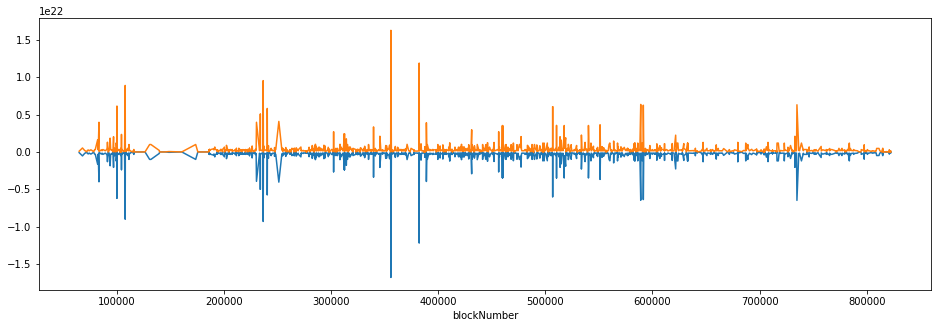

In [17]:
ax = (-1*df_exchange['sellamount']).plot()
ax1 = (df_exchange['buyamount']).plot()

exchanger     67
buyamount     67
sellamount    67
soldgold      67
dtype: int64


exchanger     3286
buyamount     3286
sellamount    3286
soldgold      3286
dtype: int64

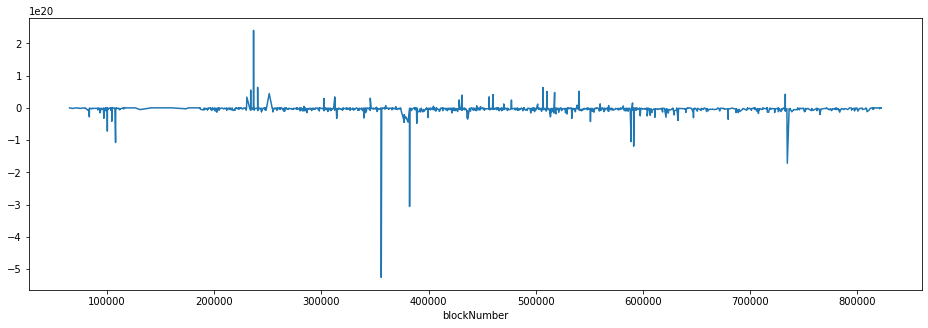

In [18]:
ax2 = (df_exchange['buyamount']-df_exchange['sellamount']).plot()
print(df_exchange[df_exchange.soldgold].count())
df_exchange[df_exchange.soldgold == False].count()
